In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:
%cd '/content/drive/MyDrive/Speech-Recognition'
%ls

/content/drive/MyDrive/Speech-Recognition
 best_model.h5   best_model.hdf5   input/  'Speech Recognition.ipynb'


# Lấy dữ liệu


In [ ]:
import os
import librosa
import IPython.display as ipd
import matplotlib.pyplot as plt
import numpy as np
from scipy.io import wavfile
import warnings
warnings.filterwarnings("ignore")
train_audio_path = 'input/train_split/'
labels=os.listdir(train_audio_path)

remove_text = '.ipynb_checkpoints'
if remove_text in labels : 
  labels.remove('.ipynb_checkpoints')
size_test = len(labels)

[50, 50, 50, 50, 50, 50, 50]


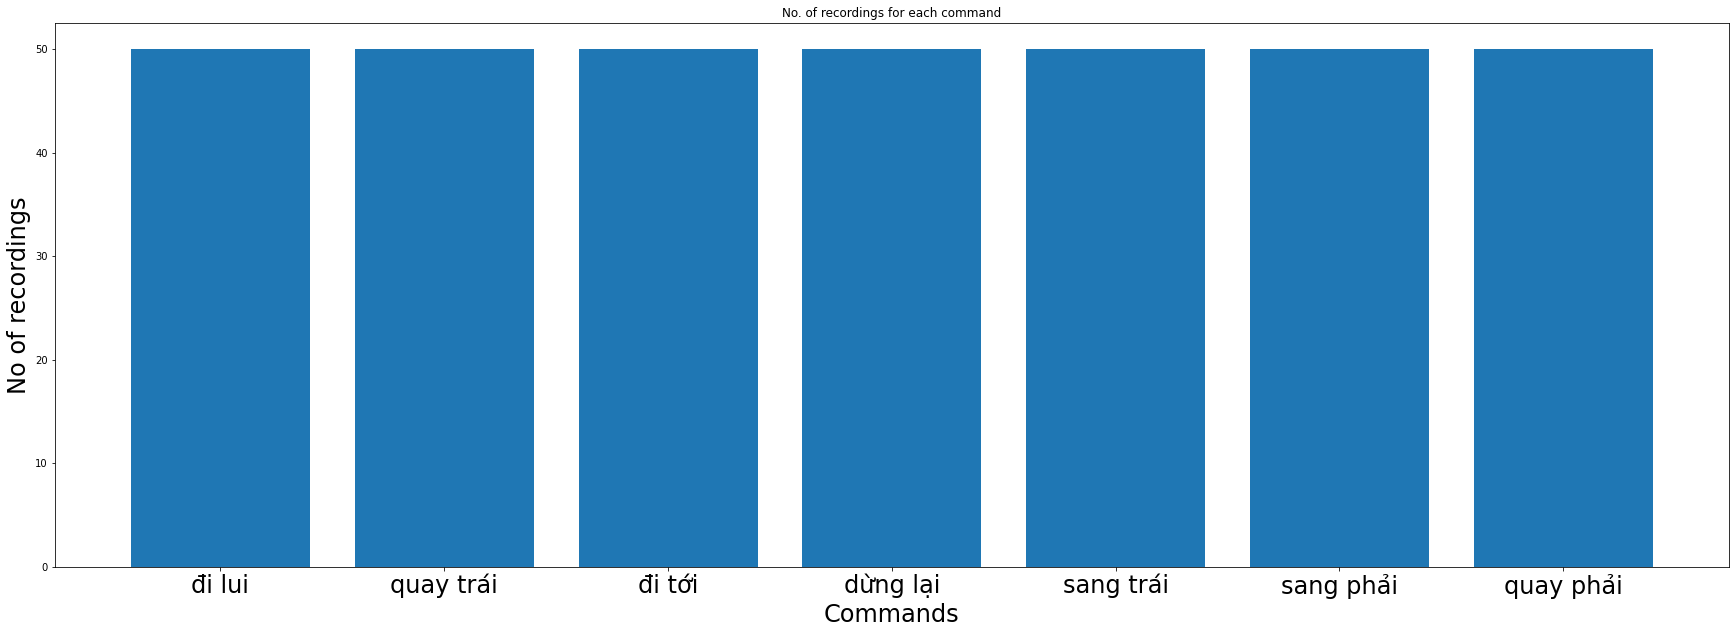

In [ ]:
#find count of each label and plot bar graph
no_of_recordings=[]
for label in labels:
    waves = [f for f in os.listdir(train_audio_path + '/'+ label) if f.endswith('.wav')]
    no_of_recordings.append(len(waves))
    
#plot
plt.figure(figsize=(30,10))
index = np.arange(len(labels))
print(no_of_recordings)
plt.bar(index, no_of_recordings)
plt.xlabel('Commands', fontsize=24)
plt.ylabel('No of recordings', fontsize=24)
plt.xticks(index, labels, fontsize=24, rotation=0)
plt.title('No. of recordings for each command')
plt.show()

**Duration of recordings**

Độ dài file ghi âm 

# **Dữ liệu Train**

In [ ]:
shape = 100

In [ ]:
for label in labels:
  print(label)
  waves = [f for f in os.listdir(train_audio_path + '/'+ label) if f.endswith('.wav')]
  for wav in waves:
      samples, sample_rate = librosa.load(train_audio_path + '/' + label + '/' + wav, sr = 16000)
      samples = librosa.resample(samples, sample_rate, 8000)
      if(len(samples) <  24000) : 
          all_wave.append(samples)
          all_label.append(label)

In [ ]:
def Calculate_Energy(data, frames, samplerate = 44100):
  '''
  Hàm tính toán năng lượng 
  '''
  data0 = [i**2 for i in data] 
  E = np.empty(1, dtype=np.int64)
  samplein10 = int(samplerate * 0.01)
  for i in range(frames):
      c = np.empty(1, dtype=np.int64)
      for j in range(samplein10):
          c = np.append(c, data0[i * samplein10 + j])
      c = np.delete(c, 0) # xoa junk value
      d = np.sum(c)
      E = np.append(E, d)
  E = np.delete(E, 0) # xoa junk value 
  return E

In [ ]:
def Detect_Voice(E) :
  '''
  Hàm xác định tiếng nói dựa theo ngưỡng
  '''
  maxE = np.amax(E)
  E = E / maxE

  draw = [] 
  new_list = []
  nguong_y = 0.1
  check = 0
  for m in range(len(E)-3) :
    if E[m] > nguong_y and check==0 :
      a = True
      for i in range(m,m+3) :
          if (E[i] < nguong_y) :
              a = False
              break
      if (a == True) :
          draw.append(m)
          check=1
    elif E[m] < nguong_y and check==1 :
      a=True
      for i in range(m,m+3):
        if (E[i] > nguong_y):
            a=False
            break
      if(a==True):
          draw.append(m-1)
          check=0

  if len(draw) >= 2 :
    new_list = E[draw[0] : draw[-1]]
    max_length = shape 
    if (len(new_list) > max_length) :
      different = len(new_list) - max_length
      first_part = E[draw[0]:draw[1]]
      second_part = E[draw[1] + different + 1: draw[-1] + 1 ]    # để có thể lấy thêm thằng cuối       
      new_list =  np.concatenate((first_part, second_part))

    elif len(new_list) < max_length :
      different = len(new_list) - max_length
      list_choices = E[draw[1] : draw[1] + different ] 
      first_part = E[draw[0] : draw[1]]
      second_part = E[draw[1] + different + 1  : draw[-1] + 1]    # để có thể lấy thêm thằng cuối    
      new_list = np.concatenate((first_part,list_choices, second_part)) 

  return new_list 

In [ ]:
train_audio_path = 'input/train_split/'
all_wave = [] 
all_label = []

for label in labels:
  waves = [f for f in os.listdir(train_audio_path + '/'+ label) if f.endswith('.wav')] # get waves files
  for wav in waves:
    samples, sample_rate = librosa.load(train_audio_path + '/' + label + '/' + wav, sr = 44100) # 
    data  = []

    # đưa dữ liệu từ 2 kênh về 1 kênh
    if len(samples.shape) == 2:
        if samples.shape[1] !=  1 :
            for i in range(len(samples)):
                data.append(samples[i][1])
    else : 
        data = samples

    frames = (float)((len(data) / sample_rate))
    frames = (int)(frames*100)

    E = Calculate_Energy(data, frames) # tính năng lượng
    new_list =  Detect_Voice(E) 
                  
    if len(new_list) == shape :
      # dán nhãn 
      all_wave.append(new_list) , all_label.append(label)    
                                                                                                                                    , all_wave.append(new_list) , all_label.append(label) ,#all_wave.append(new_list), all_label.append(label) 
    else : 
      continue

Convert the output labels to integer

In [ ]:
from sklearn.preprocessing import LabelEncoder
from keras.utils import np_utils

le = LabelEncoder()
y=le.fit_transform(all_label)
classes= list(le.classes_)
y=np_utils.to_categorical(y, num_classes=len(labels))

classes

['dừng lại',
 'quay phải',
 'quay trái',
 'sang phải',
 'sang trái',
 'đi lui',
 'đi tới']

## Create input shape

In [ ]:
input_shape = (shape,1)

In [ ]:
all_wave = np.array(all_wave).reshape(-1,shape,1) # shape same with len of sample 

## Create Model 

In [ ]:
from keras.layers import Dense, Dropout, Flatten, Conv1D, Input, MaxPooling1D
from keras.models import Model
from keras.callbacks import EarlyStopping, ModelCheckpoint
from keras import backend as K
K.clear_session()

inputs = Input(shape=input_shape) # Input shape has len same with data
dropout_rate = 0.2

#First Conv1D layer
conv = Conv1D(8, kernel_size=5, padding='valid', activation='relu', strides=1)(inputs)
conv = MaxPooling1D(2)(conv)
conv = Dropout(dropout_rate)(conv)

#Second Conv1D layer
conv = Conv1D(16,3, padding='valid', activation='relu', strides=1)(conv)
conv = Dropout(dropout_rate)(conv)

#Third Conv1D layer
conv = Conv1D(32, 2, padding='valid', activation='relu', strides=1)(conv)
conv = Dropout(0.3)(conv)

#Flatten layer
conv = Flatten()(conv)
#Dense Layer 1
conv = Dense(64, activation='relu')(conv)
conv = Dropout(dropout_rate)(conv)
#Dense Layer 2
conv = Dense(32, activation='relu')(conv)
conv = Dropout(dropout_rate)(conv)

outputs = Dense(len(labels), activation='softmax')(conv)

model = Model(inputs, outputs)
model.summary()

Model: "model"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_1 (InputLayer)         [(None, 100, 1)]          0         
_________________________________________________________________
conv1d (Conv1D)              (None, 96, 8)             48        
_________________________________________________________________
max_pooling1d (MaxPooling1D) (None, 48, 8)             0         
_________________________________________________________________
dropout (Dropout)            (None, 48, 8)             0         
_________________________________________________________________
conv1d_1 (Conv1D)            (None, 46, 16)            400       
_________________________________________________________________
dropout_1 (Dropout)          (None, 46, 16)            0         
_________________________________________________________________
conv1d_2 (Conv1D)            (None, 45, 32)            1056  

## Train Validation Test

**Split into train and validation set**

Train the model on 80% of the data and validate on the remaining 20%:

Test size is 0.2 that means 20%


In [ ]:
from sklearn.model_selection import train_test_split
x_tr, x_val, y_tr, y_val = train_test_split(np.array(all_wave),np.array(y),stratify=y,test_size = 0.25, random_state=1, shuffle=True)

Early stopping and model checkpoints are the callbacks to stop training the neural network at the right time and to save the best model after every epoch:

In [ ]:
model.compile(loss='categorical_crossentropy',optimizer='adam',metrics=['accuracy'])
es = EarlyStopping(monitor='val_loss', mode='min', verbose=1, 
                   patience= 20, min_delta=0.0001) # kết thúc sớm với 20 giá trị giống nhau thì ngắt
mc = ModelCheckpoint('best_model.h5', monitor='val_accuracy', 
                     verbose=1, save_best_only=True, mode='max')

### **Train dữ liệu thu được**

In [ ]:
history=model.fit(x_tr, y_tr ,epochs = 200, callbacks=[es,mc], batch_size = 8, validation_data=(x_val,y_val))

Epoch 1/200
61/61 [==============================] - 1s 9ms/step - loss: 1.9486 - accuracy: 0.1428 - val_loss: 1.9167 - val_accuracy: 0.1988

Epoch 00001: val_accuracy improved from -inf to 0.19876, saving model to best_model.h5
Epoch 2/200
61/61 [==============================] - 0s 5ms/step - loss: 1.8988 - accuracy: 0.2403 - val_loss: 1.8302 - val_accuracy: 0.3168

Epoch 00002: val_accuracy improved from 0.19876 to 0.31677, saving model to best_model.h5
Epoch 3/200
61/61 [==============================] - 0s 5ms/step - loss: 1.8267 - accuracy: 0.2598 - val_loss: 1.7865 - val_accuracy: 0.3043

Epoch 00003: val_accuracy did not improve from 0.31677
Epoch 4/200
61/61 [==============================] - 0s 6ms/step - loss: 1.7452 - accuracy: 0.3362 - val_loss: 1.7218 - val_accuracy: 0.4099

Epoch 00004: val_accuracy improved from 0.31677 to 0.40994, saving model to best_model.h5
Epoch 5/200
61/61 [==============================] - 0s 5ms/step - loss: 1.7184 - accuracy: 0.3459 - val_loss:

##Trực quan hóa dữ liệu sau khi Train/Test


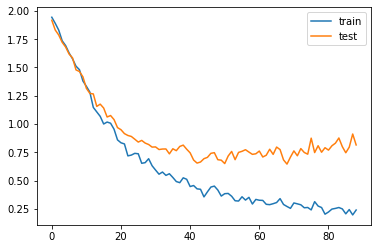

In [ ]:
from matplotlib import pyplot
pyplot.plot(history.history['loss'], label='train')
pyplot.plot(history.history['val_loss'], label='test')
pyplot.legend()
pyplot.show()

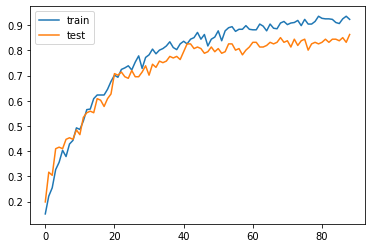

In [ ]:
from matplotlib import pyplot 
pyplot.plot(history.history['accuracy'], label='train') 
pyplot.plot(history.history['val_accuracy'], label='test') 
pyplot.legend() 
pyplot.show()

# Test


## **Loading the best model**

In [ ]:
from keras.models import load_model
model=load_model('best_model.h5')

Define the function that predicts text for the given audio:

In [ ]:
def predict(audio):
    prob=model.predict(audio.reshape(1,shape,1))  # same len of data
    index=np.argmax(prob[0])
    return classes[index]

***Prediction*** :  Make predictions on the validation data: ( Dự đoán )


In [ ]:
filepath='input/voice-commands/test'
waves = [f for f in os.listdir(filepath + '/') if f.endswith('.wav')]
for wav in waves:
    samples, sample_rate = librosa.load(filepath + '/' + wav, sr = 44100)
    data  = []
    if len(samples.shape) == 2:
        if samples.shape[1] !=  1 :
            for i in range(len(samples)):
                data.append(samples[i][1])
    else : 
        data = samples

    frames = (float)((len(samples) / sample_rate))
    frames = (int)(frames*100)

    E = Calculate_Energy(data, frames)
    new_list = Detect_Voice(E)
    if len(new_list) == shape : 
      file_predict = predict(new_list)             
      print(wav + " : " + file_predict)
    else:
      print("NO VOICE DETECT")
      continue

ditoi_tue_03.wav : đi tới
dunglai_tue_05.wav : dừng lại
sangphai_tue_05.wav : sang phải
dilui_tue_06.wav : đi lui
sangtrai_tue_03.wav : sang trái
quayphai_tue_09.wav : quay phải
quaytrai_tue_07.wav : quay trái
dilui_DLN_05.wav : đi lui
dunglai_DLN_06.wav : dừng lại
ditoi_DLN_03.wav : đi tới
quaytrai_DLN_04.wav : quay trái
quayphai_DLN_04.wav : quay phải
NO VOICE DETECT
sangphai_DLN_06.wav : quay phải
sangtrai_DLN_04.wav : sang trái
ditoi_Dat_07.wav : đi tới
dilui_Dat_10.wav : đi lui
dunglai_Dat_04.wav : dừng lại
quayphai_Dat_05.wav : quay phải
quaytrai_Dat_05.wav : quay trái
sangtrai_Dat_05.wav : sang trái
